# Analyze models
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh
##### date: March 20, 2022


## Python stuff

In [1]:
import sys, imp, os, copy

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp

import scipy.stats as stats
import seaborn as sns

import experiment_settings
import file_methods, plots, data_processing

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  
print(f"tensorflow-probability version = {tfp.__version__}")  

python version = 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]
numpy version = 1.22.2
xarray version = 2022.3.0
tensorflow version = 2.7.0
tensorflow-probability version = 0.15.0


## User Choices

In [3]:
EXP_NAME = 'exp0'
PLOT_SEED = 1257

#-------------------------------------------------------

settings = experiment_settings.get_settings(EXP_NAME)
display(settings)

MODEL_DIRECTORY = 'saved_models/'        
PREDICTIONS_DIRECTORY = 'saved_predictions/'
DATA_DIRECTORY = 'data/'
DIAGNOSTICS_DIRECTORY = 'model_diagnostics/'
FIGURE_DIRECTORY = 'figures/'

{'save_model': True,
 'n_models': 10,
 'ssp': '370',
 'gcmsub': 'ALL',
 'obsdata': 'BEST',
 'target_temp': 1.5,
 'n_train_val_test': (7, 2, 1),
 'baseline_yr_bounds': (1850, 1899),
 'training_yr_bounds': (1970, 2100),
 'anomaly_yr_bounds': (1951, 1980),
 'anomalies': True,
 'remove_map_mean': False,
 'network_type': 'shash2',
 'hiddens': [10, 10],
 'dropout_rate': 0.0,
 'ridge_param': [1.0, 0.0],
 'learning_rate': 1e-05,
 'batch_size': 64,
 'rng_seed': 8889,
 'seed': None,
 'act_fun': ['relu', 'relu'],
 'n_epochs': 25000,
 'patience': 50,
 'exp_name': 'exp0'}

## Initial housekeeping

In [4]:
## determine how many GCMs are being used
filenames = file_methods.get_cmip_filenames(settings, verbose=0)
N_GCMS = len(filenames)

# load observations for diagnostics plotting
da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
N_TRAIN, N_VAL, N_TEST, ALL_MEMBERS = data_processing.get_members(settings)

observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)


## Plotting Functions

In [5]:
FS = 16

### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## Load the observations predictions

In [6]:
rng = np.random.default_rng(settings["rng_seed"])
pred_obs_vec = np.zeros(shape=(settings['n_models'], x_obs.shape[0], 2))*np.nan

for iloop in np.arange(settings['n_models']):
    seed = rng.integers(low=1_000,high=10_000,size=1)[0]
    settings["seed"] = int(seed)

    # get model name
    model_name = file_methods.get_model_name(settings)
    filename = PREDICTIONS_DIRECTORY+model_name + '_obs_predictions.pickle'
    if os.path.exists(filename):
        obs_pred_seed = pd.read_pickle(filename)
        pred_obs_vec[iloop,:,0] = obs_pred_seed[:,0] 
        pred_obs_vec[iloop,:,1] = obs_pred_seed[:,1] 
    else:
        print(model_name  +" does not exist. Skipping...") 
        print("================================\n")
        continue    
        #----------------------------------------
        
    if seed == PLOT_SEED:
        obs_pred_plot = copy.deepcopy(obs_pred_seed)
        model_name_plot = copy.deepcopy(model_name)

print("done.")

done.


## Plot spread in $\mu$ across random seeds

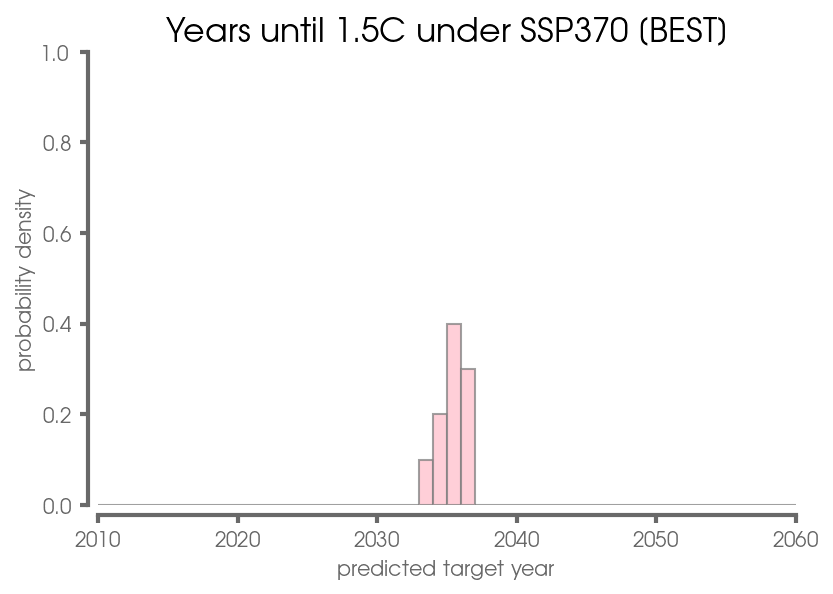

In [7]:
INPUT_YEAR = 2021
iyear = np.where(da_obs["time.year"]==INPUT_YEAR)[0]

perc_low = np.percentile(pred_obs_vec[:,iyear,0],25)
perc_high = np.percentile(pred_obs_vec[:,iyear,0],25)

plt.figure()
plt.hist(INPUT_YEAR+pred_obs_vec[:,iyear,0],
         bins=np.arange(1850,2100),
         color="pink",
         edgecolor='gray',
         alpha=.75,
         density=True,
        )
plt.axvline(x=perc_low,
            linestyle='--',
            color="pink",
           )
plt.axvline(x=perc_high,
            linestyle='--',
            color="pink",            
           )

plt.xticks(np.arange(1850,2100,10),np.arange(1850,2100,10))
plt.yticks(np.arange(0,1.2,.2),np.arange(0,1.2,.2).round(1))
plt.xlim(2010,2060)
plt.ylim(0,1)
plt.xlabel('predicted target year')
plt.ylabel('probability density')

ax = plt.gca()
format_spines(ax)

plt.title('Years until ' + str(settings["target_temp"]) + 'C under SSP' + settings["ssp"] + ' [' + settings["obsdata"] + ']',
          color='k',
          fontsize=16,
         )

plt.savefig(FIGURE_DIRECTORY + settings["exp_name"] + '_spread_mu' + '.png', dpi=savefig_dpi)
plt.show()

## Plot Single Seed Obs

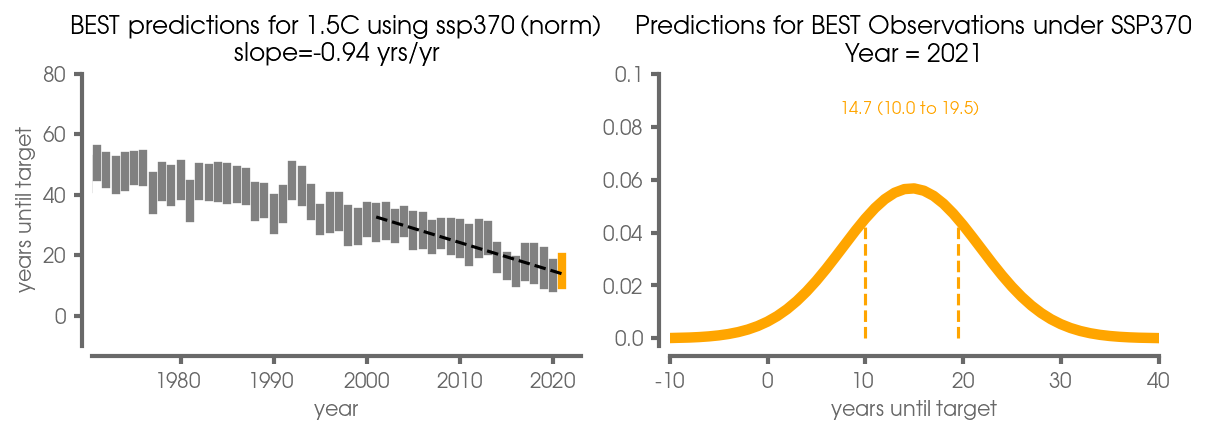

In [8]:
clr_choice = 'orange'
y_predict_obs = obs_pred_seed

iy = np.where(da_obs['time.year'].values >= 2001)[0]
x = da_obs['time.year'].values[iy]
y = y_predict_obs[iy,0]
linear_model = stats.linregress(x=x,y=y)

#--------------------------------
norm_incs = np.arange(-80,80,1)
mu_pred = y_predict_obs[:,0]
sigma_pred = y_predict_obs[:,1]
norm_dist = tfp.distributions.Normal(mu_pred,sigma_pred)
norm_perc_low = norm_dist.quantile(.25).numpy()   
norm_perc_high = norm_dist.quantile(.75).numpy()      
norm_perc_med = norm_dist.quantile(.5).numpy()      
norm_cpd = norm_dist[-1].prob(norm_incs)
y_predict_obs = norm_perc_med

pred_text = str(mu_pred[-1].round(1)) + ' (' + str(norm_perc_low[-1].round(1)) + ' to ' + str(norm_perc_high[-1].round(1)) + ')'

#------------------------------------------------------------
ax = plt.subplots(1,2,figsize=(8,3))
years = np.arange(1850,2022)

plt.subplot(1,2,1)
for iyear in np.arange(0,y_predict_obs.shape[0]):
    min_val = norm_perc_low[iyear]
    max_val = norm_perc_high[iyear]

    if(years[iyear]==2021):
        clr = clr_choice
    else:
        clr = 'gray'
    plt.plot((years[iyear],years[iyear]),(min_val, max_val),
             linestyle='-',
             linewidth=4,
             color=clr,
            )

plt.plot(x,x*linear_model.slope+linear_model.intercept,'--', color='black')

plt.xticks(np.arange(1850,2100,10),np.arange(1850,2100,10))
plt.yticks(np.arange(-100,100,20),np.arange(-100,100,20).round(0))
plt.ylabel('years until target')
plt.xlabel('year')
plt.title(settings["obsdata"] + ' predictions for ' + str(settings['target_temp']) + 'C using ssp' + settings["ssp"] + ' (norm)\n slope=' + str(linear_model.slope.round(2)) +" yrs/yr")

plt.xlim(1970.5,2023)    
plt.ylim(-10,80)
format_spines(plt.gca())

plt.subplot(1,2,2)
plt.plot(norm_incs,norm_cpd,
         linewidth=5,
         color=clr_choice,
        )

k = np.argmin(np.abs(norm_perc_low[-1]-norm_incs))
plt.plot((norm_perc_low[-1],norm_perc_low[-1]),(0,norm_cpd[k]),'--',color=clr_choice)
k = np.argmin(np.abs(norm_perc_high[-1]-norm_incs))
plt.plot((norm_perc_high[-1],norm_perc_high[-1]),(0,norm_cpd[k]),'--',color=clr_choice)

plt.text(mu_pred[-1],
         .09,
         pred_text,         
         horizontalalignment="center",
         verticalalignment="top",
         color="orange",
         fontsize=8,
        )
         

plt.xlabel('years until target')
plt.title('Predictions for ' + settings["obsdata"] + ' Observations under SSP' + settings["ssp"] + '\nYear = 2021')
plt.xticks(np.arange(-50,50,10),np.arange(-50,50,10))
plt.yticks(np.arange(0,.12,.02),np.arange(0,.12,.02).round(2))

if settings["target_temp"] == 1.1:
    plt.xlim(-20,20)
elif settings["target_temp"] == 1.5:
    plt.xlim(-10,40)
elif settings["target_temp"] == 2.0:
    plt.xlim(-10,70)
else:
    plt.xlim(-70,70)
    
format_spines(plt.gca())
plt.tight_layout()

plt.savefig(FIGURE_DIRECTORY + model_name_plot + '_obs_timeseries_spread' + '.png', dpi=savefig_dpi)
plt.show()